In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage
import math
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from collections import Counter
import seaborn as sns


import utils as ut

In [2]:
imDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/images/hires/"

keyMap = {
    '1105-LM-1C' : 'HFD8',
    '1105-LM-1D' : 'HFD14', 
    '1105-LM-1B' : 'ND',
}

imgs = {}

for f in os.listdir(imDir):
    if f.endswith("tif"):
        SPTkey = f.replace(".tif", "")
        if not SPTkey in keyMap.keys():
            continue
        
        fullpath = f"{imDir}{f}"
        img = skimage.io.imread(fullpath, as_gray=True)
        key = keyMap[SPTkey]
        print(key, img.shape)
        imgs[key] = img

print('done')

HFD8 (39147, 33122)
HFD14 (40713, 33149)
ND (39460, 33174)
done


(2000, 2000)


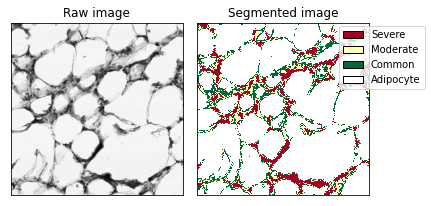

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 10

ws = 1000
key = "HFD14"
img = imgs[key]

xCenter = img.shape[1] // 2
yCenter = img.shape[0] // 2

xLb = xCenter - ws 
xUb = xCenter + ws 
yLb = yCenter - ws 
yUb = yCenter + ws 

# trim image 
img = img[yLb:yUb, xLb:xUb]
print(img.shape)


nClasses = 4
colors = ut.ncolor(nClasses-1, cmap='RdYlGn')
colors.insert(nClasses-1, "w")

thresholds = skimage.filters.threshold_multiotsu(img, classes=nClasses)
# Using the threshold values, we generate the three regions.
regions = np.digitize(img, bins=thresholds)
training_labels = regions + 1

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max) 
                        # channel_axis=-1)

features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)


fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

axs[0].imshow(img, cmap='binary_r')
axs[0].grid(True)
axs[0].set_title("Raw image")
axs[0].set_xticks([])
axs[0].set_yticks([])

cmap = mpl.colors.ListedColormap(colors)

axs[1].imshow(result, cmap=cmap)
axs[1].set_title("Segmented image")
axs[1].grid(True)
axs[1].set_xticks([])
axs[1].set_yticks([])

handles = []

colorMap = {}

labelMap = {
    1 : "Severe",
    2 : "Moderate",
    3 : "Common",
    4 : "Adipocyte",
}

for i, c in enumerate(colors):
    colorMap[i+1] = c
    lab = labelMap[i+1]
    handle = mpatches.Patch(color=c, 
                            ec='k', 
                            label=lab)
    handles.append(handle)
    
plt.legend(handles=handles, bbox_to_anchor=(1.35, 1.015))
plt.tight_layout()

([], [])

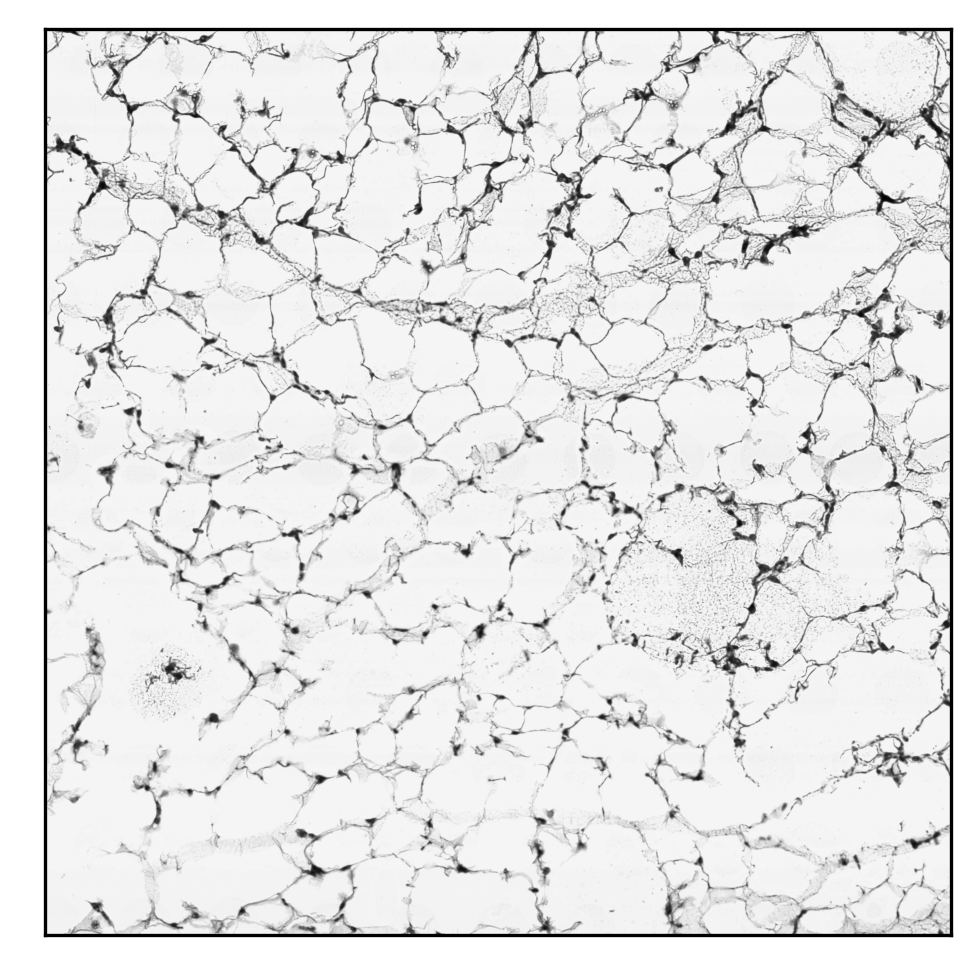

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

ws = 2000
key = "ND"
img = imgs[key]

xCenter = img.shape[1] // 2
yCenter = img.shape[0] // 2

xLb = xCenter - ws 
xUb = xCenter + ws 
yLb = yCenter - ws 
yUb = yCenter + ws 

# trim image 
img = img[yLb:yUb, xLb:xUb]

plt.imshow(img, cmap='binary_r')
plt.xticks([])
plt.yticks([])

In [5]:
# break

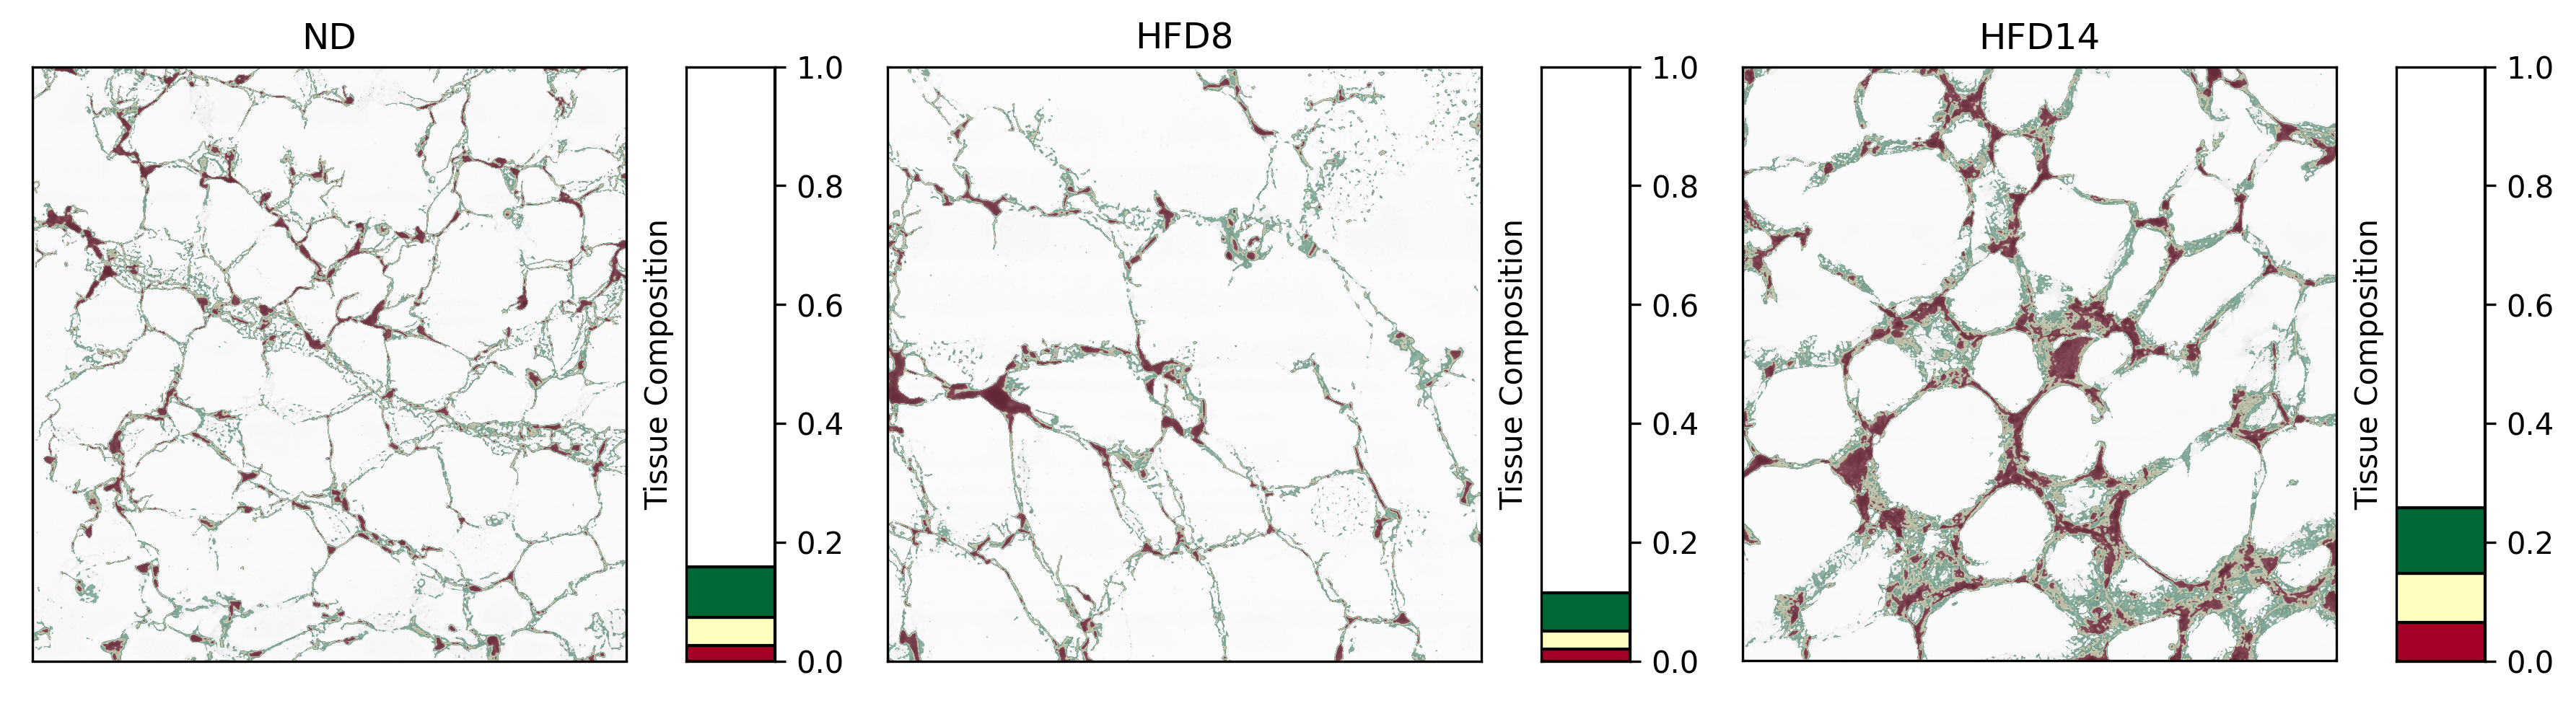

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 4

keys = ['ND', 'HFD8', 'HFD14']

sampleSize = 1
gStd = 0.5
ws = 1000

def clip(img, x, y, ws):
    xLb = x - ws 
    xUb = x + ws 
    yLb = y - ws 
    yUb = y + ws 
    return img[yLb:yUb, xLb:xUb]


def gauss2d(mu, sigma, size):
    x = np.random.normal(mu, sigma, size)
    y = np.random.normal(mu, sigma, size)
    return (x, y)


fig, axs = plt.subplots(1, 3)

for i, key in enumerate(keys):
    
    fullImg = imgs[key]
    yDim, xDim = fullImg.shape
    
    xCenter = (xDim // 2) - 1000
    yCenter = (yDim // 2) - 1000
        
    window = clip(fullImg, xCenter, yCenter, ws)
    
    features = features_func(window)
    result = future.predict_segmenter(features, clf)
    
    # get label Counts
    counts = Counter(list(result.ravel()))
    
    # get colors
    cols = [colorMap[k] for k in counts]

    axs[i].imshow(window, 
                  cmap='binary_r', 
                  alpha=0.5, 
                  zorder=2)
    axs[i].imshow(result, 
                  cmap=cmap, 
                  alpha=0.7, )
    axs[i].set_title(f"{key}")
    axs[i].grid(True)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    
    ax_divider = make_axes_locatable(axs[i])
    ax2 = ax_divider.append_axes("right", 
                                 size="15%", 
                                 pad=f"10%")
    
    prop = pd.DataFrame.from_dict(counts, orient='index').reset_index(drop=False)
    prop.columns = ['LabelIdx', 'Count']
    prop['Percent'] = prop['Count'] / prop['Count'].sum()
    prop['Label'] = prop['LabelIdx'].map(labelMap)
    prop['Color'] = prop['LabelIdx'].map(colorMap)
    prop = prop.sort_values(by='LabelIdx')
    prop['Bottom'] = prop['Percent'].cumsum().shift().fillna(0)

    for idx, row in prop.iterrows():
        ax2.bar("prop", 
                row['Percent'], 
                color=row['Color'], 
                bottom=row['Bottom'], 
                ec='k')
        
    ax2.set_xticks([])
    # ax2.set_yticks([])
    ax2.set_ylim([0, 1])
    ax2.set_xlim([0, 0.4])
    # if i == 2:
    ax2.set_ylabel("Tissue Composition")
    
    # ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    
plt.tight_layout()

In [7]:
counts

Counter({2: 330619, 3: 442452, 1: 260161, 4: 2966768})

In [8]:
# break

In [24]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 10

sampleSize = 500
gStd = 0.1
ws = 400

res = []


for i, key in enumerate(keys):
    
    fullImg = imgs[key]
    yDim, xDim = fullImg.shape
    
    xCenter = xDim // 2
    yCenter = yDim // 2
    
    print(key, xCenter, yCenter)
    
    # get sample coordinate-offsets
    sx, sy = gauss2d(0, gStd, sampleSize)
    
    
    sx = (sx * xDim) + xCenter
    sy = (sy * yDim) + yCenter

    sx = sx.astype(int)
    sy = sy.astype(int)

    
    for s in range(sampleSize):
        window = clip(fullImg, sx[s], sy[s], ws)
        features = features_func(window)
        result = future.predict_segmenter(features, clf)
        
        counts = Counter(list(result.ravel()))
        row = {
            'key' : key,
            'imageX' : sx[s],
            'imageY' : sy[s],
        }
        for k, v in counts.items():
            label = f"Label{k}"
            row[label] = v / window.size
            
        res.append(row)

res = pd.DataFrame(res)
res.head()

ND 16587 19730
HFD8 16561 19573
HFD14 16574 20356


,key,imageX,imageY,Label4,Label3,Label2,Label1
0,ND,17385,19250,0.855345,0.089139,0.042052,0.013464
1,ND,20110,24732,0.829192,0.098777,0.044250,0.027781
2,ND,11513,17506,0.835642,0.090164,0.045584,0.028609
3,ND,13355,18356,0.874739,0.067586,0.038150,0.019525
4,ND,17422,20189,0.763056,0.135942,0.056787,0.044214


In [25]:
res.head()

,key,imageX,imageY,Label4,Label3,Label2,Label1
0,ND,17385,19250,0.855345,0.089139,0.042052,0.013464
1,ND,20110,24732,0.829192,0.098777,0.044250,0.027781
2,ND,11513,17506,0.835642,0.090164,0.045584,0.028609
3,ND,13355,18356,0.874739,0.067586,0.038150,0.019525
4,ND,17422,20189,0.763056,0.135942,0.056787,0.044214


Text(0.5, 0, 'Proportion Severe')

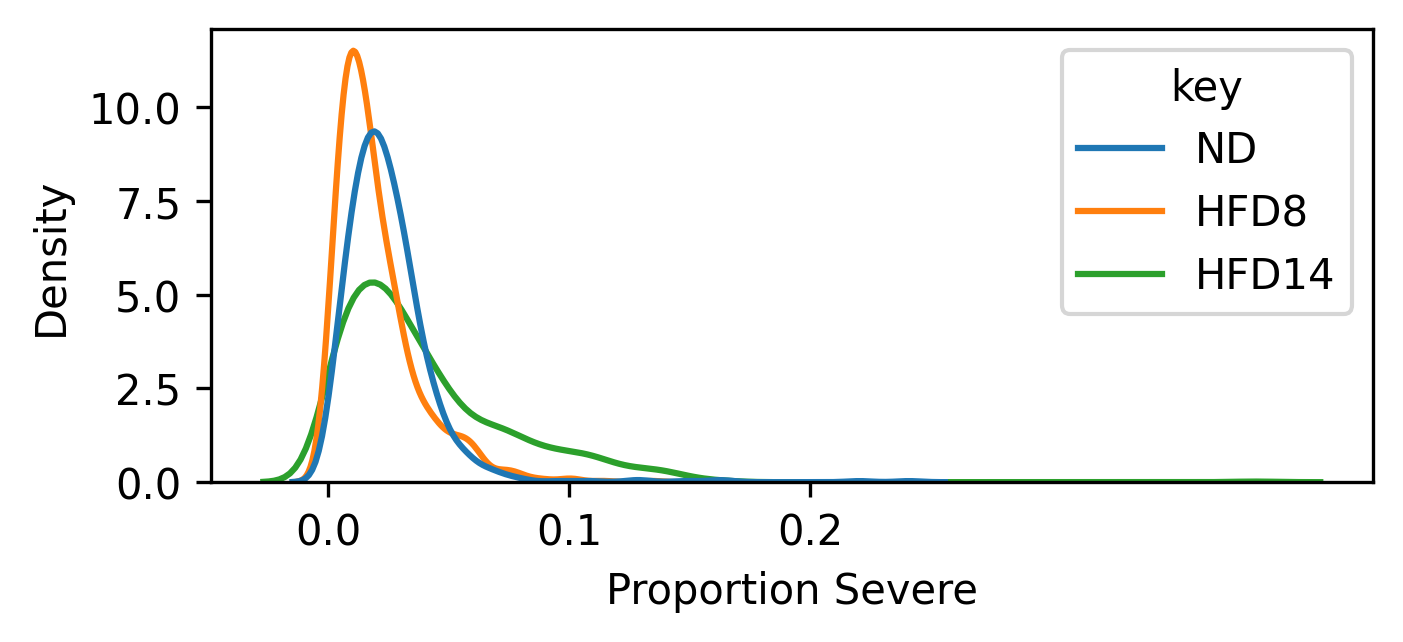

In [22]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 2
sns.kdeplot(data=res, 
            x='Label1', 
            hue='key',)

# plt.yscale("log")
# plt.ylabel(f'Count')
# plt.xlabel(f'Proportion of Windows Severe')

lb = 0
ub = 0.2

nTiks = 3
tiks = np.linspace(lb, ub, nTiks)
plt.xticks(tiks)

plt.xlabel(f'Proportion Severe')

Text(0.5, 0, 'Proportion Moderate')

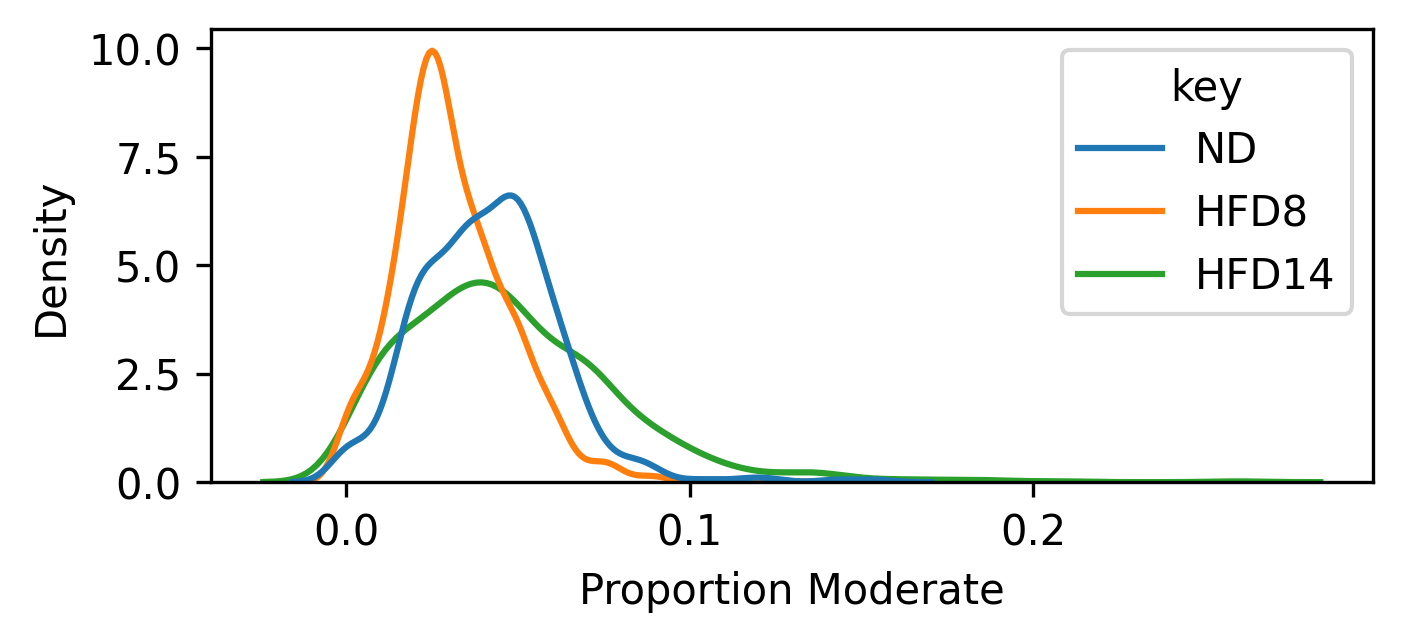

In [23]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 2
sns.kdeplot(data=res, 
            x='Label2', 
            hue='key',)

# plt.yscale("log")
# plt.ylabel(f'Count')
# plt.xlabel(f'Proportion of Windows Severe')

lb = 0
ub = 0.2

nTiks = 3
tiks = np.linspace(lb, ub, nTiks)
plt.xticks(tiks)

plt.xlabel(f'Proportion Moderate')